## Results of tuning learning rate

Comments:

By using the read weighted edge list from a csv file, it saves much space on self.graph

This will for specific batch number and hop-layer number

In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [26]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import shutil
import time

from utils import *


### Seperate steps for parameter tuning

In [29]:
def step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, \
                                    train_batch_num, net_layer_num, trainer_list): 
    
    print('Start running training for partition num: ' + str(train_batch_num))
    # set the batch for test and train
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'tuning_parameters/'  # further subfolder for different task

    # start to summarize the results into images for output

    test_accuracy, test_f1, time_total_train, time_data_load = summarize_tuning_res(img_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, trainer_list)

    generate_tuning_raw_data_table(test_accuracy, img_path, 'test_acc.csv', tune_param_name)
    test_accuracy_file = store_data_multi_tuning(tune_val_list, test_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_accuracy_file, data_name, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Accuracy')

    generate_tuning_raw_data_table(test_f1, img_path, 'test_f1.csv', tune_param_name)
    test_f1_file = store_data_multi_tuning(tune_val_list, test_f1, data_name, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_f1_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'F1 score')

    generate_tuning_raw_data_table(time_total_train, img_path, 'time_train_total.csv', tune_param_name)
    time_train_file = store_data_multi_tuning(tune_val_list, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_train_file, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Train Time (ms)')

    generate_tuning_raw_data_table(time_data_load, img_path, 'time_load_data.csv', tune_param_name)
    time_load_file = store_data_multi_tuning(tune_val_list, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_load_file, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Load Time (ms)')
 
def step41_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, \
                                    train_batch_num, net_layer_num, trainer_list): 
    """
        Train investigation post-processing
        Train-validation at the same time
    """
    print('Start summarizing for train batch num: ' + str(train_batch_num) )
    # set the batch for validation and train
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'investigation_figures/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    # start to summarize the results into images for output

    Train_peroid_f1, Train_peroid_accuracy = summarize_investigation_res(img_path, intermediate_data_path, trainer_list)

#     Train_peroid_f1_file = store_data_multi_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'invest_batch_num_' + str(train_batch_num))
#     draw_data_multi_tests(Train_peroid_f1_file, data_name, 'Train_process_batch_num_' + str(train_batch_num), 'epoch number', 'F1 score')

#     Train_peroid_accuracy_file = store_data_multi_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'invest_batch_num_' + str(train_batch_num) )
#     draw_data_multi_tests(Train_peroid_accuracy_file, data_name, 'Train_process_batch_num_' + str(train_batch_num), 'epoch number', 'Accuracy')
    
    
    Train_peroid_f1_file = store_data_each_trainer_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_f1_file, data_name, 'validation', 'epoch number', 'F1 score')
    
    Train_peroid_accuracy_file = store_data_each_trainer_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_accuracy_file, data_name, 'validation', 'epoch number', 'Accuracy')
    
def check_train_loss_converge(image_path, mini_batch_folder, subfolder, data_name, trainer_id = 0):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + subfolder
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer_time = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer_time))
    
    # store the resulting data on the disk
    train_loss_path = image_path + 'trainer_loss/' + subfolder
    os.makedirs(os.path.dirname(train_loss_path), exist_ok=True)
    loss_res_file = train_loss_path + 'loss_trainer_' + str(trainer_id)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, gcn_trainer)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node(loss_res_file)

### Use data from GraphSaint dataset

### Output for the model clusterGCN/GraphSage

In [41]:
data_name = 'PPI_small'
test_folder_name = 'clusterGCN/'
intermediate_data_folder = './'
# here we can switch between models
image_data_path = intermediate_data_folder + 'clusterGCN_results/' + data_name + '/' + test_folder_name
# image_data_path = intermediate_data_folder + 'GraphSage_results/' + data_name + '/' + test_folder_name

# this is the parts we divide the graph
origin_train_batch_num = 32
round_num = 1
train_batch_num = round_num * origin_train_batch_num

# here only the number of layers matter 
GCN_layer = [128, 128]
net_layer_num = len(GCN_layer) + 1
# for non-optimization: hop_layer_num == net_layer_num
hop_layer_num = net_layer_num



### Generate validation F1-score during training

Start summarizing for train batch num: 32
Start summarizing for train batch num: 32


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/Post_processing_Large_graph_HPC/tune_learning_rate/utils.py:370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figu

Start summarizing for train batch num: 32


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/Post_processing_Large_graph_HPC/tune_learning_rate/utils.py:370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/Post_processing_Large_graph_HPC/tune_learning_rate/utils.py:370: RuntimeWarning: More than 20 fig

Start summarizing for train batch num: 32


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/Post_processing_Large_graph_HPC/tune_learning_rate/utils.py:370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/Post_processing_Large_graph_HPC/tune_learning_rate/utils.py:370: RuntimeWarning: More than 20 fig

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

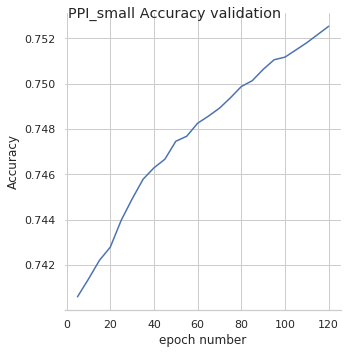

In [42]:

tune_param_name = 'learning_rate'
tune_val_label_list = [1, 2, 3, 4]
# tune_val_label_list = [5]
tune_val_list = [label for label in tune_val_label_list]
trainer_list = list(range(3))
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    step41_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label, tune_val, \
                                    train_batch_num, net_layer_num, trainer_list)

In [36]:
!ls ./GraphSage_results/PPI_large/clusterGCN/cluster_num_64/net_layer_num_3/investigation_figures/tune_learning_rate_1/

PPI_large_Accuracy_validation_img_trainer_0.png
PPI_large_Accuracy_validation_img_trainer_1.png
PPI_large_Accuracy_validation.pkl
PPI_large_F1_score_validation_img_trainer_0.png
PPI_large_F1_score_validation_img_trainer_1.png
PPI_large_F1_score_validation.pkl
res_trainer_0
res_trainer_1


### Results after fixed number of epochs

In [ ]:
tune_param_name = 'mini_epoch_num'
tune_val_label_list = [1, 5, 10, 20]
tune_val_list = [label for label in tune_val_label_list]
trainer_list = list(range(7))

step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label_list, tune_val_list, \
                                    train_batch_num, net_layer_num, trainer_list)

### Check training loss

In [ ]:
tune_param_name = 'mini_epoch_num'
trainer_list = list(range(7))
# output for the train loss
tuning_path = intermediate_data_folder + 'GraphSaint_dataset_results/' + data_name + '/' + 'GCN_tuning/'
for tune_val in tune_val_list:
    trainer_path = tuning_path + 'tune_' + tune_param_name + '_' + str(tune_val) + '/'
    img_path = image_data_path + 'train_loss/tune_val_' + str(tune_val) + '/'
    check_train_loss_converge(img_path, trainer_path, data_name, trainer_id = 0)

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)